# CS767 - Final Project - Movie Genre Prediction 

## Import libraries

In [1]:
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import nltk
nltk.download('stopwords')
from ast import literal_eval
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
## Load dataset

In [3]:
data = pd.read_csv('C:\movies_metadata.csv')
data.head()

c:\users\aksha\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497                en   
2                                   NaN  15602  tt0113228                en   
3                                   NaN  31357  tt0114885                en   
4                                   NaN  11862  tt0113041                en   

                original_title  \
0                    Toy Story   
1                      Jumanji   
2             Grumpier Old Men   
3            Waiting to Exhale   
4  Father of the Bride Part II   

                                            overview  ... release_date  \
0  Led by Woody, Andy's toys live happily in his ...  ...   1995-10-30   
1  When siblings Judy and Peter discover an encha...  ...   1995-12-15   
2  A family wedding reignites the ancient feud be...  ...   1995-12-22   
3  Cheated on, mistreated and stepped on, the wom...  ...   1995-12-22   
4  Just when George Banks has recovered from his ...  ...   1995-02-10   

       revenue runtime                                   spoken_languages  \
0  373554033.0    81.0           [{'iso_639_1': 'en', 'name': 'English'}]   
1  262797249.0   104.0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...   
2          0.0   101.0           [{'iso_639_1': 'en', 'name': 'English'}]   
3   81452156.0   127.0           [{'iso_639_1': 'en', 'name': 'English'}]   
4   76578911.0   106.0           [{'iso_639_1': 'en', 'name': 'English'}]   

     status                                            tagline  \
0  Released                                                NaN   
1  Released          Roll the dice and unleash the excitement!   
2  Released  Still Yelling. Still Fighting. Still Ready for...   
3  Released  Friends are the people who let you be yourself...   
4  Released  Just When His World Is Back To Normal... He's ...   

                         title  video vote_average vote_count  
0                    Toy Story  False          7.7     5415.0  
1                      Jumanji  False          6.9     2413.0  
2             Grumpier Old Men  False          6.5       92.0  
3            Waiting to Exhale  False          6.1       34.0  
4  Father of the Bride Part II  False          5.7      173.0  

[5 rows x 24 columns]

In [4]:
data.shape

(45466, 24)

In [5]:
data.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

## Preprocessing

### Identify top genre from the list provided

In [6]:
data['newgenres'] = data['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [7]:
data["topgenre"] = data["newgenres"].str[0]

In [8]:
data[['title','topgenre', 'newgenres', 'genres']]

title   topgenre                     newgenres  \
0                        Toy Story  Animation   [Animation, Comedy, Family]   
1                          Jumanji  Adventure  [Adventure, Fantasy, Family]   
2                 Grumpier Old Men    Romance             [Romance, Comedy]   
3                Waiting to Exhale     Comedy      [Comedy, Drama, Romance]   
4      Father of the Bride Part II     Comedy                      [Comedy]   
...                            ...        ...                           ...   
45461                       Subdue      Drama               [Drama, Family]   
45462          Century of Birthing      Drama                       [Drama]   
45463                     Betrayal     Action     [Action, Drama, Thriller]   
45464             Satan Triumphant        NaN                            []   
45465                     Queerama        NaN                            []   

                                                  genres  
0      [{'id': 16, 'name': 'Animation'}, {'id': 35, '...  
1      [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...  
2      [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...  
3      [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...  
4                         [{'id': 35, 'name': 'Comedy'}]  
...                                                  ...  
45461  [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...  
45462                      [{'id': 18, 'name': 'Drama'}]  
45463  [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...  
45464                                                 []  
45465                                                 []  

[45466 rows x 4 columns]

Drop rows where topgenre is NaN

In [9]:
index = data[pd.isnull(data['topgenre'])].index
index

rows = data.index[index]

data.drop(rows, inplace=True)
data

adult                              belongs_to_collection    budget  \
0      False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1      False                                                NaN  65000000   
2      False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3      False                                                NaN  16000000   
4      False  {'id': 96871, 'name': 'Father of the Bride Col...         0   
...      ...                                                ...       ...   
45459  False                                                NaN         0   
45460  False                                                NaN         0   
45461  False                                                NaN         0   
45462  False                                                NaN         0   
45463  False                                                NaN         0   

                                                  genres  \
0      [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1      [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2      [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3      [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                         [{'id': 35, 'name': 'Comedy'}]   
...                                                  ...   
45459           [{'id': 878, 'name': 'Science Fiction'}]   
45460  [{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...   
45461  [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...   
45462                      [{'id': 18, 'name': 'Drama'}]   
45463  [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...   

                                   homepage      id    imdb_id  \
0      http://toystory.disney.com/toy-story     862  tt0114709   
1                                       NaN    8844  tt0113497   
2                                       NaN   15602  tt0113228   
3                                       NaN   31357  tt0114885   
4                                       NaN   11862  tt0113041   
...                                     ...     ...        ...   
45459                                   NaN  222848  tt0112613   
45460                                   NaN   30840  tt0102797   
45461  http://www.imdb.com/title/tt6209470/  439050  tt6209470   
45462                                   NaN  111109  tt2028550   
45463                                   NaN   67758  tt0303758   

      original_language               original_title  \
0                    en                    Toy Story   
1                    en                      Jumanji   
2                    en             Grumpier Old Men   
3                    en            Waiting to Exhale   
4                    en  Father of the Bride Part II   
...                 ...                          ...   
45459                en              Caged Heat 3000   
45460                en                   Robin Hood   
45461                fa                      رگ خواب   
45462                tl          Siglo ng Pagluluwal   
45463                en                     Betrayal   

                                                overview  ... runtime  \
0      Led by Woody, Andy's toys live happily in his ...  ...    81.0   
1      When siblings Judy and Peter discover an encha...  ...   104.0   
2      A family wedding reignites the ancient feud be...  ...   101.0   
3      Cheated on, mistreated and stepped on, the wom...  ...   127.0   
4      Just when George Banks has recovered from his ...  ...   106.0   
...                                                  ...  ...     ...   
45459  It's the year 3000 AD. The world's most danger...  ...    85.0   
45460  Yet another version of the classic epic, with ...  ...   104.0   
45461        Rising and falling between a man and woman.  ...    90.0   
45462  An artist struggles to finish his work while a...  ...   360.0   
45463  When one of her hits goes wrong, a professiona...  ...    90.0   

                  

## Convert topgenre into vector

In [10]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','))

In [11]:
tag_dtm = vectorizer.fit_transform(data['topgenre'])
tag_dtm

<43024x23 sparse matrix of type '<class 'numpy.int64'>'
	with 43024 stored elements in Compressed Sparse Row format>

In [12]:
print("Number of data points: ", tag_dtm.shape[0])#of entries
print("Number of unique tags: ", tag_dtm.shape[1]) #of total labels

Number of data points:  43024
Number of unique tags:  23


In [13]:
#some of the tags are:

tags = vectorizer.get_feature_names()
print("Some of the tags we have :" , tags[1:5])

Some of the tags we have : ['adventure', 'animation', 'aniplex', 'carousel productions']


In [14]:
### Number of times a tag appeared

In [15]:
#Lets now store the document term matrix in dictionary

freqs = tag_dtm.sum(axis=0).A1
print(freqs)

[ 4489  1514  1124     1     1  8820  1685  3415 11966   524   704   118
   279  2619   487   554     1  1191   647  1665   390   379   451]


In [16]:
count_tags = dict(zip(tags, freqs))
print(count_tags)

{'action': 4489, 'adventure': 1514, 'animation': 1124, 'aniplex': 1, 'carousel productions': 1, 'comedy': 8820, 'crime': 1685, 'documentary': 3415, 'drama': 11966, 'family': 524, 'fantasy': 704, 'foreign': 118, 'history': 279, 'horror': 2619, 'music': 487, 'mystery': 554, 'odyssey media': 1, 'romance': 1191, 'science fiction': 647, 'thriller': 1665, 'tv movie': 390, 'war': 379, 'western': 451}


In [17]:
#saving it to a CSV files. 

if not os.path.isfile('dt2tag_counts_dict_dtm.csv'):
    with open('dt2tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key,value])
tag_df = pd.read_csv("dt2tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

Tags  Counts
0                action    6931
1             adventure    1514
2             animation    1124
3               aniplex       1
4  carousel productions       1

In [18]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

print(tag_df_sorted)
print(tag_counts)

                    Tags  Counts
8                  drama   11966
5                 comedy    8820
0                 action    6931
7            documentary    3415
13                horror    2619
6                  crime    1685
19              thriller    1665
1              adventure    1514
17               romance    1191
2              animation    1124
10               fantasy     704
18       science fiction     647
15               mystery     554
9                 family     524
14                 music     487
22               western     451
20              tv movie     390
21                   war     379
12               history     279
11               foreign     118
16         odyssey media       1
4   carousel productions       1
3                aniplex       1
[11966  8820  6931  3415  2619  1685  1665  1514  1191  1124   704   647
   554   524   487   451   390   379   279   118     1     1     1]


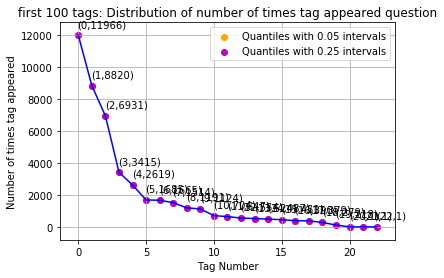

In [19]:
plt.plot(tag_counts, c='b')
plt.scatter(x=list(range(0,23)), y=tag_counts[0:23:], c='orange', label='Quantiles with 0.05 intervals')
plt.scatter(x=list(range(0,23)), y = tag_counts[0:23:], c='m', label = 'Quantiles with 0.25 intervals')

for x,y in zip(list(range(0,23)), tag_counts[0:23]):
    plt.annotate(s="({},{})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))
    

plt.title('first 100 tags: Distribution of number of times tag appeared question')
plt.grid()
plt.xlabel("Tag Number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()

In [20]:
### Top 20 tags

<Figure size 1440x720 with 0 Axes>

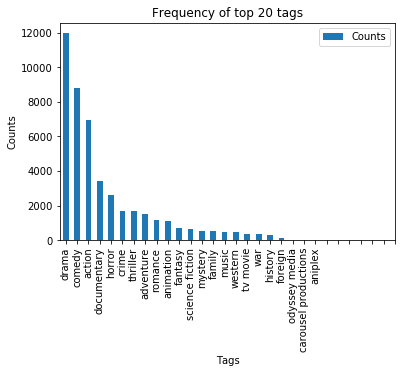

In [21]:
i= np.arange(30)
fig = plt.figure(figsize=(20,10))
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i,tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()


### Removing HTML tags, punctuation, special characters


In [22]:
def cleanHTML(sentence):
    cleanr=re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

In [23]:
# remove all punctuation
def cleanPunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,)|(|\|/)]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

### Remove alhpa numeric and covert to lowercase

In [24]:
def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+',' ',word)
        alpha_sent+= alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

In [25]:
data['overview'] = data['overview'].str.lower()
data['overview'] = data['overview'].apply(cleanHTML)
data['overview'] = data['overview'].apply(cleanPunc)
data['overview'] = data['overview'].apply(keepAlpha)

In [26]:
print(data['overview'][1]) #print a particular synopsis

when siblings judy and peter discover an enchanted board game that opens the door to a magical world they unwittingly invite alan   an adult whos been trapped inside the game for   years   into their living room alans only hope for freedom is to finish the game which proves risky as all three find themselves running from giant rhinoceroses evil monkeys and other terrifying creatures


### Remove stopwords present in text using default set of stop-words from NLTK library

In [27]:
stop_words = set(stopwords.words('english'))
stop_words.update(['zero', 'one' , 'two' , 'three', 'four' , 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'may', 'also'
                  'across' , 'among', 'beside', 'however', 'yet', 'within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words)+ ")\\W", re.I)
def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

data['overview'] = data['overview'].apply(removeStopWords)
print(data['overview'][1])

 siblings judy  peter discover  enchanted board game  opens  door   magical world  unwittingly invite alan    adult whos  trapped inside  game    years     living room alans  hope  freedom   finish  game  proves risky    find  running  giant rhinoceroses evil monkeys   terrifying creatures


### Stemming - using SnowBallStemmer

In [28]:
stemmer = SnowballStemmer("english")

def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence+= stem
        stemSentence+= " "
    #print(stemSentence)
    stemSentence = stemSentence.strip()
    return stemSentence


In [29]:
data['preprocessed_data'] = data['overview'].apply(stemming)
print(data['preprocessed_data'][1])

sibl judi peter discov enchant board game open door magic world unwit invit alan adult whos trap insid game year live room alan hope freedom finish game prove riski find run giant rhinoceros evil monkey terrifi creatur


### Comparing Stemming and Lemmatization

In [30]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

df = pd.DataFrame(['this was cheesy', 'she likes these books', 'wow this is great'], columns=['text'])
df['text_lemmatized'] = df.text.apply(lemmatize_text)
df['stemming']=df.text.apply(stemming)
df

text           text_lemmatized             stemming
0        this was cheesy        [this, wa, cheesy]      this was cheesi
1  she likes these books  [she, like, these, book]  she like these book
2      wow this is great    [wow, this, is, great]    wow this is great

In [31]:
#data['preprocessed_data'] = data.preprocessed_data.apply(lemmatize_text)
#print(data['preprocessed_data'][1])

### Splitting the data into test and training data

In [32]:
x = data['preprocessed_data']
y = data['topgenre']

from sklearn.model_selection import train_test_split

In [33]:
random_state = np.random.RandomState(0)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(x,y,
                                                   test_size=0.2, random_state=random_state)

In [35]:
print(y_test)

24685       Drama
39965     Romance
31805     Western
41091       Crime
14968      Horror
           ...   
21661      Comedy
8991        Drama
22744       Drama
32573    Thriller
4346       Comedy
Name: topgenre, Length: 8605, dtype: object


### Feature extraction using TF-IDF

In [36]:
## TF_IDF

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df = 10, max_features = 20000, 
                             smooth_idf = True,  strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer.fit(x_train)
x_train_13char = vectorizer.transform(x_train)
x_test_13char = vectorizer.transform(x_test)

print(x_train_13char)


  (0, 13372)	0.18793357199475952
  (0, 13176)	0.1672166369679934
  (0, 13171)	0.1473608658014322
  (0, 12296)	0.19622879562259915
  (0, 12172)	0.20383490286423836
  (0, 12135)	0.1927867499718316
  (0, 11339)	0.11566267928091682
  (0, 11205)	0.20255358972098186
  (0, 10891)	0.10570688242497377
  (0, 10760)	0.16034506303224105
  (0, 10396)	0.19902817457251962
  (0, 10375)	0.15728752717731487
  (0, 10034)	0.16904542189016847
  (0, 9391)	0.22597595120597422
  (0, 8382)	0.1507497678308137
  (0, 6811)	0.16484196167976353
  (0, 6116)	0.23931573010020393
  (0, 6017)	0.1527169854448263
  (0, 5915)	0.23931573010020393
  (0, 5744)	0.21841581019615725
  (0, 5717)	0.11765657469088163
  (0, 5456)	0.21495827274451243
  (0, 3012)	0.14491744881008609
  (0, 2797)	0.40594841170856877
  (0, 1044)	0.23012732491013757
  :	:
  (34417, 11042)	0.3662146741435918
  (34417, 10618)	0.35940659794221763
  (34417, 9724)	0.5176131362166506
  (34417, 2638)	0.4025889585999684
  (34418, 13258)	0.21770728202391634
  (344

### Base model

In [37]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets

# f1_score import 
from sklearn.metrics import f1_score

In [38]:
##We will use sk-learn’s OneVsRestClassifier class to solve this problem as a Binary Relevance or one-vs-all problem:

In [39]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [40]:
##Finally, fit the model on the train set:

In [41]:
# fit model on train data
clf.fit(x_train_13char, y_train)

c:\users\aksha\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [42]:
# make predictions for validation set
y_pred = clf.predict(x_test_13char)
y_pred

array(['Action', 'Drama', 'Action', ..., 'Comedy', 'Drama', 'Drama'],
      dtype='<U20')

In [75]:
# evaluate performance
f1_LROVA = f1_score(y_test, y_pred, average="micro")
f1_LROVA

0.38396281231841956

In [44]:
# f1_score import 
from sklearn.metrics import precision_score, accuracy_score


In [45]:
print('The Macro precision score  is: ' , precision_score(y_test, y_pred,average='macro'))
print('The Micro precision score  is: ' , precision_score(y_test, y_pred,average='micro'))
print('The Weighted precision score  is: ' , precision_score(y_test, y_pred,average='weighted'))

The Macro precision score  is:  0.28639102959224777
The Micro precision score  is:  0.46670540383497966
The Weighted precision score  is:  0.42184601561248497


c:\users\aksha\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=y_test.unique()))

c:\users\aksha\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                 precision    recall  f1-score   support

          Drama       0.46      0.48      0.47       914
        Romance       0.39      0.11      0.17       308
        Western       0.47      0.16      0.23       199
          Crime       0.00      0.00      0.00         1
         Horror       0.47      0.59      0.52      1749
        Fantasy       0.24      0.07      0.10       317
         Comedy       0.70      0.62      0.66       655
        History       0.44      0.75      0.55      2398
         Action       0.00      0.00      0.00       123
        Mystery       0.50      0.01      0.03       150
      Animation       0.00      0.00      0.00        26
Science Fiction       0.00      0.00      0.00        57
    Documentary       0.50      0.44      0.47       507
         Family       0.60      0.04      0.07        79
      Adventure       0.00      0.00      0.00       134
          Music       0.00      0.00      0.00       231
       Thriller       0.38    

### Word2vec

In [47]:
## convert to list for Word2vec
def convert(sentence): 

    sentence = re.sub("[^\w]", " ",  sentence).split()
    return sentence

In [48]:
data['preprocessed_data1'] = data['preprocessed_data'].apply(convert)
print(data['preprocessed_data1'])

0        [led, woodi, andi, toy, live, happili, room, a...
1        [sibl, judi, peter, discov, enchant, board, ga...
2        [famili, wed, reignit, ancient, feud, next, do...
3        [cheat, mistreat, step, women, hold, breath, w...
4        [georg, bank, recov, daughter, wed, receiv, ne...
                               ...                        
45459    [year, ad, world, danger, women, banish, remot...
45460    [anoth, version, classic, epic, enough, variat...
45461                             [rise, fall, man, woman]
45462    [artist, struggl, finish, work, storylin, cult...
45463    [hit, goe, wrong, profession, assassin, end, s...
Name: preprocessed_data1, Length: 43024, dtype: object


In [49]:
x1 = data['preprocessed_data1']

In [50]:
x1_train, x1_test, y1_train, y1_test = train_test_split(x1,y,
                                                   test_size=0.2, random_state=random_state)

In [51]:
from gensim.models import Word2Vec

w2v = Word2Vec(x1_train, size=350, window=5, min_count=2, iter=20)

unable to import 'smart_open.gcs', disabling that module


New words are added to vocabulary

In [52]:
words = list(w2v.wv.vocab)
print(words)

['priest', 'offici', 'convent', 'sudden', 'transform', 'devil', 'frighten', 'away', 'nun', 'turn', 'place', 'outlet', 'pandemonium', 'born', 'god', 'rais', 'man', 'perseus', 'helpless', 'save', 'famili', 'hade', 'veng', 'underworld', 'noth', 'lose', 'volunt', 'lead', 'danger', 'mission', 'defeat', 'seiz', 'power', 'zeus', 'unleash', 'hell', 'earth', 'battl', 'unholi', 'demon', 'fearsom', 'beast', 'warrior', 'surviv', 'accept', 'defi', 'fate', 'creat', 'destini', 'cop', 'day', 'mask', 'crusad', 'night', 'fearless', 'sultri', 'black', 'scorpion', 'must', 'protect', 'citi', 'angel', 'dead', 'trio', 'villain', 'prosthet', 'machin', 'gun', 'firearm', 'time', 'control', 'vision', 'steal', 'suburb', 'tokyo', 'ago', 'live', 'clumsi', 'boy', 'year', 'old', 'appear', 'front', 'name', 'sewashi', 'nobita', 'descend', 'generat', 'later', 'nd', 'centuri', 'doraemon', 'cat', 'type', 'caretak', 'robot', 'help', 'peopl', 'secret', 'gadget', 'claim', 'suffer', 'debt', 'made', 'even', 'order', 'chang', '

In [53]:
sim_words = w2v.most_similar('love')
sim_words

c:\users\aksha\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('passion', 0.5270593166351318),
 ('asleep', 0.45330625772476196),
 ('politico', 0.45318371057510376),
 ('uro', 0.45054298639297485),
 ('romanc', 0.44825538992881775),
 ('clara', 0.43543553352355957),
 ('spell', 0.4333471655845642),
 ('merivel', 0.4223264753818512),
 ('niagara', 0.41910678148269653),
 ('tonia', 0.4173458516597748)]

In [54]:
word_vectors = w2v.wv.vectors
word_vectors

array([[-0.2309998 ,  1.0599633 , -1.1713233 , ..., -0.3502775 ,
         0.07107995,  0.20104514],
       [-0.06754217, -0.04922004, -0.3012104 , ...,  0.84980166,
         0.89496547,  0.39462423],
       [-0.09777305, -1.1182749 ,  0.63178897, ..., -1.8124833 ,
        -2.2854733 ,  1.4742504 ],
       ...,
       [ 0.09877558, -0.03585615,  0.02315303, ..., -0.02782588,
        -0.01481232,  0.02298745],
       [ 0.06136502,  0.04589256,  0.08593602, ..., -0.03690046,
        -0.03553757,  0.04638492],
       [-0.02815621,  0.03067095,  0.0574305 , ...,  0.08643437,
         0.04259809, -0.01501449]], dtype=float32)

In [55]:
WordVectorz=dict(zip(w2v.wv.index2word,w2v.wv.vectors))
WordVectorz

{'life': array([-2.30999798e-01,  1.05996335e+00, -1.17132330e+00,  1.00423205e+00,
        -4.94371343e-04, -6.68293774e-01,  2.17879367e+00, -9.71525133e-01,
        -3.76338623e-02, -6.78258419e-01, -6.45002902e-01,  8.37888271e-02,
         7.08982229e-01,  8.01459670e-01, -4.76763457e-01, -1.93908677e-01,
        -4.54611033e-01, -2.72760779e-01,  1.38169134e+00,  2.73268908e-01,
         6.24933600e-01,  2.90932238e-01,  6.10858917e-01,  1.28370810e+00,
        -1.33437383e+00, -5.70022225e-01, -5.00919461e-01,  1.31137633e+00,
        -3.35113287e-01,  1.18030155e+00, -5.60511887e-01, -8.69310141e-01,
         6.56564534e-01, -1.07772875e+00, -7.55935371e-01, -1.12448835e+00,
        -9.70431030e-01, -3.77306938e-01,  1.83107483e+00,  8.12638700e-01,
        -1.30603981e+00,  8.47165356e-04,  3.02937161e-02,  5.99589586e-01,
         8.18217918e-02,  4.15860415e-01,  1.09567463e+00,  3.77448916e-01,
         7.45885521e-02,  2.20984554e+00, -7.20862091e-01,  1.62409270e+00,
    

## Model 2 - Neural Network

In [56]:
from sklearn import preprocessing
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


# Label Encoding for Target

In [57]:
classes = y_train.unique()
classes

array(['Action', 'Crime', 'Comedy', 'Adventure', 'Drama', 'Documentary',
       'Horror', 'Family', 'Mystery', 'War', 'Animation', 'Romance',
       'Thriller', 'Fantasy', 'Science Fiction', 'TV Movie', 'Western',
       'History', 'Music', 'Foreign', 'Carousel Productions',
       'Odyssey Media'], dtype=object)

In [58]:
print ("Label Encode the Target Variable ... ")
lb = preprocessing.LabelEncoder()
print(y_train)
y_train = lb.fit_transform(y_train)
dummy_y_train = np_utils.to_categorical(y_train)
dummy_y_train

Label Encode the Target Variable ... 
2240          Action
21817          Crime
39345         Comedy
20028         Comedy
13045      Adventure
            ...     
33418         Family
31599         Comedy
21812         Action
45006    Documentary
2804           Drama
Name: topgenre, Length: 34419, dtype: object


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [77]:
print ("Create model ... ")
def build_model():
    model = Sequential()
    model.add(Dense(500, input_dim=x_train_13char.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(22, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

Create model ... 


In [60]:
x_train_13char.shape

(34419, 13991)

In [ ]:
print("Compile model ...")
estimator = KerasClassifier(build_fn=build_model, epochs=15, batch_size=128)
estimator.fit(x_train_13char, dummy_y_train)

Compile model ...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 500)               6996000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               100200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 22)                4422      
Total params: 7,100,622
Trainable params: 7,100,622
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
 8064/34419 [======>.......................] - ETA: 53s - loss: 2.4932 - accuracy

In [62]:
# Predictions 
print ("Predict on test data ... ")
y_pred = estimator.predict(x_test_13char)
y_pred

Predict on test data ... 


array([ 0,  7, 21, ..., 19, 19,  4])

In [63]:
lb1 = preprocessing.LabelEncoder()
print(y_train)
y_test = lb1.fit_transform(y_test)
dummy_y_test = np_utils.to_categorical(y_test)
dummy_y_test

[0 5 4 ... 0 6 7]


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [66]:
print('The Macro precision score  is: ' , precision_score(y_test, y_pred,average='macro'))
print('The Micro precision score  is: ' , precision_score(y_test, y_pred,average='micro'))
print('The Weighted precision score  is: ' , precision_score(y_test, y_pred,average='weighted'))

The Macro precision score  is:  0.16090603767280345
The Micro precision score  is:  0.3839628123184195
The Weighted precision score  is:  0.35580283333946433


In [74]:
f1_NN=f1_score(y_test, y_pred, average="micro")
f1_NN

0.38396281231841956

In [68]:
accuracy_score(y_test, y_pred1)

NameError: name 'y_pred1' is not defined

In [72]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=classes))

                      precision    recall  f1-score   support

              Action       0.38      0.39      0.38       914
               Crime       0.23      0.18      0.20       308
              Comedy       0.27      0.25      0.26       199
           Adventure       0.00      0.00      0.00         1
               Drama       0.45      0.50      0.47      1749
         Documentary       0.18      0.16      0.17       317
              Horror       0.59      0.59      0.59       655
              Family       0.45      0.54      0.49      2398
             Mystery       0.10      0.05      0.06       123
                 War       0.13      0.09      0.10       150
           Animation       0.00      0.00      0.00        26
             Romance       0.03      0.02      0.02        57
            Thriller       0.41      0.41      0.41       507
             Fantasy       0.18      0.18      0.18        79
     Science Fiction       0.10      0.04      0.06       134
       

In [70]:
temp.plot()

AttributeError: 'str' object has no attribute 'plot'

AttributeError: 'numpy.float64' object has no attribute 'plot'